In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import statsmodels.api as sm
from scipy import stats
import numpy as np
from sklearn.preprocessing import LabelEncoder
from statsmodels.miscmodels.ordinal_model import OrderedModel

## Loading data (SQLite)

In [2]:
conn = sqlite3.connect('/app/Data/release_db.sqlite')
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in the database:")
for table in tables:
    print(table[0])
conn.close()


Tables in the database:
sites
sqlite_sequence
alexa_ranks
policy_texts
policy_htmls
policy_reader_view_htmls
policy_snapshots


In [3]:
conn = sqlite3.connect('/app/Data/release_db.sqlite')
cursor = conn.cursor()

cursor.execute("SELECT COUNT(*) FROM policy_texts")
policy_texts_count = cursor.fetchone()[0]

cursor.execute("SELECT COUNT(*) FROM sites")
sites_count = cursor.fetchone()[0]

cursor.execute("SELECT COUNT(*) FROM policy_snapshots")
snapshots_count = cursor.fetchone()[0]

conn.close()

print(f"policy_texts rows: {policy_texts_count}")
print(f"sites rows: {sites_count}")
print(f"policy_snapshots rows: {snapshots_count}")

policy_texts rows: 333986
sites rows: 130620
policy_snapshots rows: 1071487


In [4]:
def load_combined_data(chunksize=50000):
    conn = sqlite3.connect('/app/Data/release_db.sqlite')
    
    query = """
    SELECT 
        s.domain,
        s.categories,
        pt.flesch_kincaid,
        pt.smog,
        pt.flesch_ease,
        ps.year,
        ps.phase,
        ar.rank as alexa_rank
    FROM 
        sites s
    JOIN 
        policy_snapshots ps ON s.id = ps.site_id
    JOIN 
        policy_texts pt ON ps.policy_text_id = pt.id
    LEFT JOIN
        alexa_ranks ar ON s.id = ar.site_id AND ps.year = ar.year
    """
    
    chunks = []
    for chunk in pd.read_sql_query(query, conn, chunksize=chunksize):
        print(f"Loaded chunk of size: {len(chunk)}")
        chunks.append(chunk)
        
    conn.close()
    
    return pd.concat(chunks, ignore_index=True)

# Load the combined data
df = load_combined_data()
print(f"Total rows loaded: {len(df)}")


Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 20814
Total rows loaded: 1

In [ ]:
df.head()

,domain,categories,flesch_kincaid,smog,flesch_ease,year,phase,alexa_rank
0,docusign.com,business;informationtech,14.938384,18.351184,difficult,2003,B,NaN
1,docusign.com,business;informationtech,13.762202,18.171460,difficult,2004,B,NaN
2,docusign.com,business;informationtech,13.640407,18.062587,difficult,2006,B,NaN
3,docusign.com,business;informationtech,13.640407,18.062587,difficult,2006,A,NaN
4,docusign.com,business;informationtech,13.762202,18.171460,difficult,2004,A,NaN


In [6]:
nan_counts = df.isna().sum()
print("Number of NaN values in each column:")
print(nan_counts)

Number of NaN values in each column:
domain                 0
categories             0
flesch_kincaid     42650
smog              617166
flesch_ease        42650
year                   0
phase                  0
alexa_rank        327817
dtype: int64


## Correlation between readability scores (FK vs. SMOG)

In [7]:
# Correlation between readability scores
correlation_matrix = df[['flesch_kincaid', 'smog']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                flesch_kincaid      smog
flesch_kincaid        1.000000  0.876019
smog                  0.876019  1.000000


## Average readability over the years

### SMOG & Flesch-Kincaid 

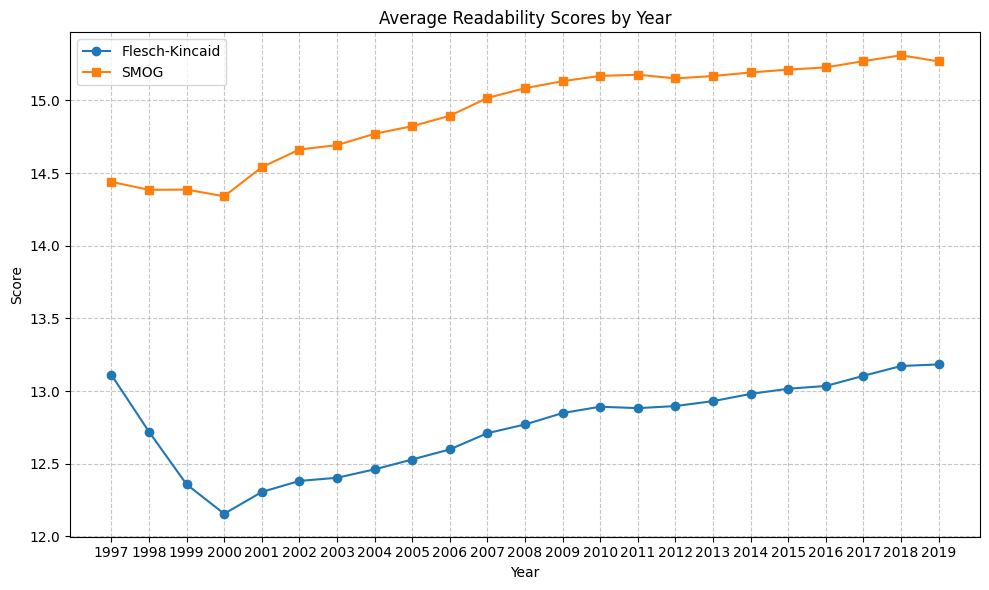

In [8]:
yearly_averages = df.groupby('year')[['flesch_kincaid', 'smog']].mean()

plt.figure(figsize=(10, 6))
plt.plot(yearly_averages.index, yearly_averages['flesch_kincaid'], marker='o', label='Flesch-Kincaid')
plt.plot(yearly_averages.index, yearly_averages['smog'], marker='s', label='SMOG')

plt.title('Average Readability Scores by Year')
plt.xlabel('Year')
plt.ylabel('Score')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(yearly_averages.index)

plt.tight_layout()
plt.show()

In [9]:
yearly_averages_reset = yearly_averages.reset_index()

def analyze_yearly_trend(score_type):
    X = sm.add_constant(yearly_averages_reset['year'])
    y = yearly_averages_reset[score_type]
    
    model = sm.OLS(y, X).fit()
    
    print(f"\nRegression Results for {score_type} (Using Yearly Averages):")
    print(model.summary().tables[1])
    
    correlation = yearly_averages_reset[['year', score_type]].corr().iloc[0,1]
    print(f"Correlation coefficient between year and {score_type}: {correlation:.4f}")

analyze_yearly_trend('flesch_kincaid')
analyze_yearly_trend('smog')



Regression Results for flesch_kincaid (Using Yearly Averages):
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -54.3159     13.196     -4.116      0.000     -81.758     -26.874
year           0.0334      0.007      5.083      0.000       0.020       0.047
Correlation coefficient between year and flesch_kincaid: 0.7427

Regression Results for smog (Using Yearly Averages):
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -78.2105      6.603    -11.845      0.000     -91.942     -64.479
year           0.0464      0.003     14.105      0.000       0.040       0.053
Correlation coefficient between year and smog: 0.9511


### Flesch_Ease (Categorical)

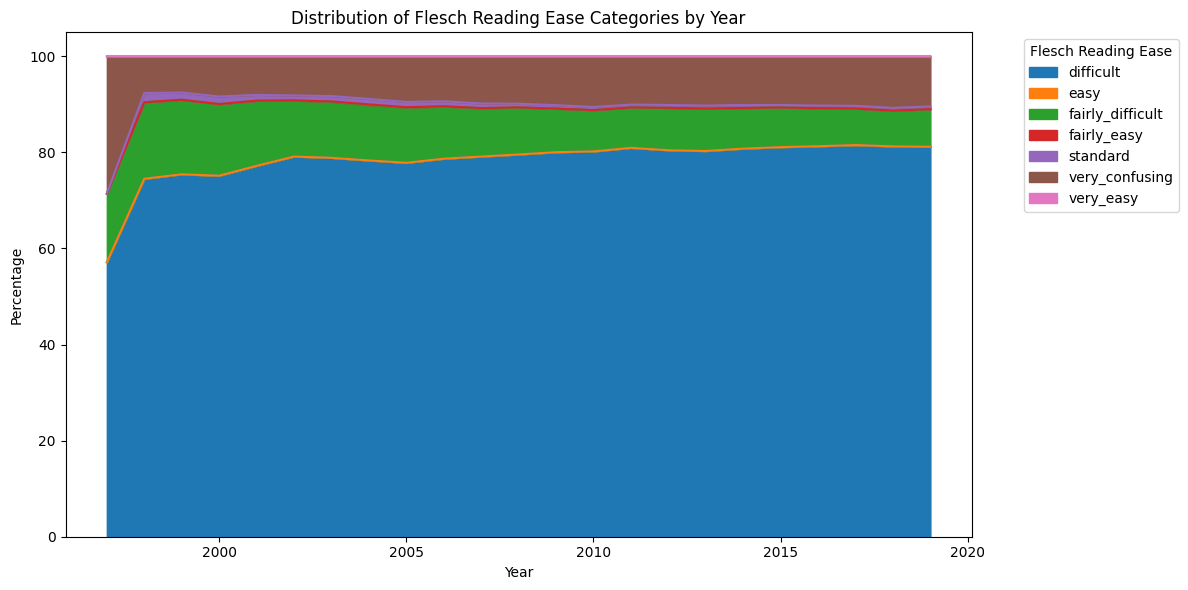

In [10]:
flesch_ease_counts = df.groupby(['year', 'flesch_ease']).size().unstack(fill_value=0)

# Normalize to get percentages
flesch_ease_percentages = flesch_ease_counts.div(flesch_ease_counts.sum(axis=1), axis=0) * 100

# Plot
plt.figure(figsize=(12, 6))
flesch_ease_percentages.plot(kind='area', stacked=True, ax=plt.gca())
plt.title('Distribution of Flesch Reading Ease Categories by Year')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend(title='Flesch Reading Ease', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [11]:
def analyze_flesch_ease_trend():
    # Calculate the mode (most common category) for each year
    yearly_mode = df.groupby('year')['flesch_ease'].agg(lambda x: x.value_counts().index[0])
    
    print("\nMost common Flesch Reading Ease category by year:")
    print(yearly_mode)
    
    # Calculate the percentage of each category for each year
    yearly_percentages = df.groupby('year')['flesch_ease'].value_counts(normalize=True).unstack()
    
    print("\nPercentage of each Flesch Reading Ease category by year:")
    print(yearly_percentages)
    
    # Test for independence between year and flesch_ease category
    contingency_table = pd.crosstab(df['year'], df['flesch_ease'])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    print(f"\nChi-square test for independence between year and Flesch Reading Ease category:")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p_value:.4f}")

analyze_flesch_ease_trend()



Most common Flesch Reading Ease category by year:
year
1997    difficult
1998    difficult
1999    difficult
2000    difficult
2001    difficult
2002    difficult
2003    difficult
2004    difficult
2005    difficult
2006    difficult
2007    difficult
2008    difficult
2009    difficult
2010    difficult
2011    difficult
2012    difficult
2013    difficult
2014    difficult
2015    difficult
2016    difficult
2017    difficult
2018    difficult
2019    difficult
Name: flesch_ease, dtype: object

Percentage of each Flesch Reading Ease category by year:
flesch_ease  difficult      easy  fairly_difficult  fairly_easy  standard  \
year                                                                        
1997          0.571429       NaN          0.142857          NaN       NaN   
1998          0.745223       NaN          0.159236          NaN  0.019108   
1999          0.754518       NaN          0.155120          NaN  0.015060   
2000          0.751526       NaN          0.149190    

In [12]:
df_dummy = pd.get_dummies(df['flesch_ease'], drop_first=True)
df_with_dummies = pd.concat([df[['year']], df_dummy], axis=1)

X = df_with_dummies
y = df['year']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   year   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.720e+26
Date:                Thu, 02 Jan 2025   Prob (F-statistic):               0.00
Time:                        11:34:03   Log-Likelihood:             3.6957e+07
No. Observations:             1720814   AIC:                        -7.391e+07
Df Residuals:                 1720806   BIC:                        -7.391e+07
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             7.718e-11   4.62e-11  

## Distribution of Flesch Kincaid

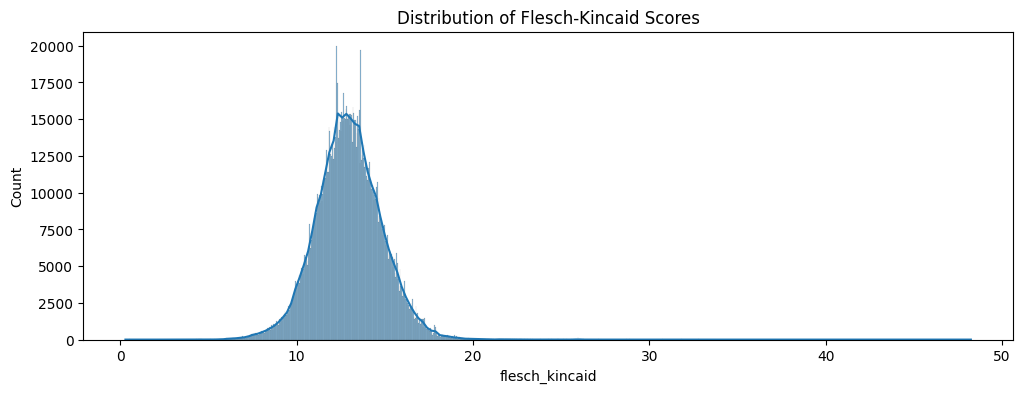

In [13]:
plt.figure(figsize=(12, 4))
sns.histplot(df['flesch_kincaid'], kde=True)
plt.title('Distribution of Flesch-Kincaid Scores')
plt.show()

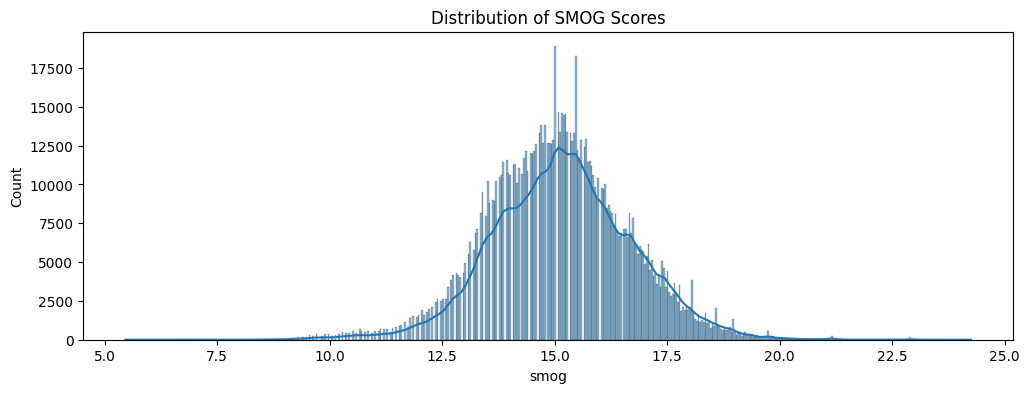

In [14]:
plt.figure(figsize=(12, 4))
sns.histplot(df['smog'], kde=True)
plt.title('Distribution of SMOG Scores')
plt.show()

## Correlation between Alexa rank and readability

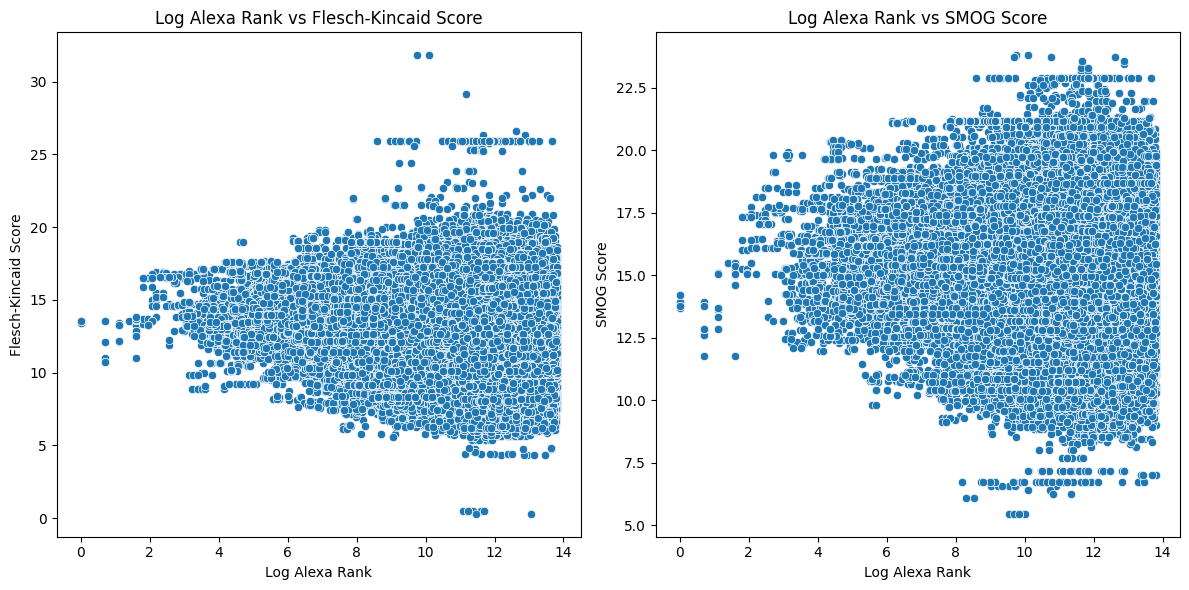

In [15]:
# Create log of Alexa rank
df['log_alexa_rank'] = np.log(df['alexa_rank'])

# Remove any infinite or NaN values
df_clean = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['log_alexa_rank', 'flesch_kincaid', 'smog'])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='log_alexa_rank', y='flesch_kincaid', data=df_clean)
plt.title('Log Alexa Rank vs Flesch-Kincaid Score')
plt.xlabel('Log Alexa Rank')
plt.ylabel('Flesch-Kincaid Score')

plt.subplot(1, 2, 2)
sns.scatterplot(x='log_alexa_rank', y='smog', data=df_clean)
plt.title('Log Alexa Rank vs SMOG Score')
plt.xlabel('Log Alexa Rank')
plt.ylabel('SMOG Score')

plt.tight_layout()
plt.show()


We use the logarithm of Alexa rank for several reasons:

* Alexa ranks follow a highly skewed distribution - the difference in visibility between rank 1 and 100 is much larger than between rank 10,000 and 10,1002
* Taking the logarithm helps normalize this skewed distribution, making the relationship between website popularity and readability scores easier to visualize and analyze2
* The log transformation is particularly useful when dealing with rankings that span several orders of magnitude, as is the case with Alexa ranks which range from 1 to over 100,0002

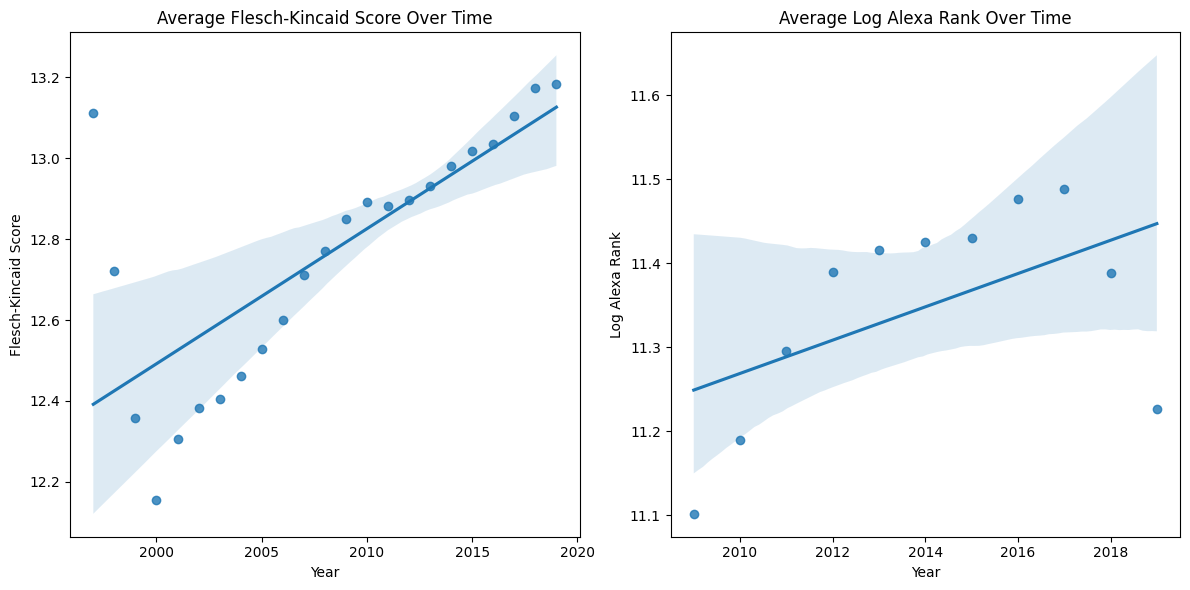

In [16]:
# Calculate average readability scores and Alexa rank by year
yearly_avg = df.groupby('year').agg({
    'flesch_kincaid': 'mean',
    'smog': 'mean',
    'log_alexa_rank': 'mean'
}).reset_index()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.regplot(x='year', y='flesch_kincaid', data=yearly_avg)
plt.title('Average Flesch-Kincaid Score Over Time')
plt.xlabel('Year')
plt.ylabel('Flesch-Kincaid Score')

plt.subplot(1, 2, 2)
sns.regplot(x='year', y='log_alexa_rank', data=yearly_avg)
plt.title('Average Log Alexa Rank Over Time')
plt.xlabel('Year')
plt.ylabel('Log Alexa Rank')

plt.tight_layout()
plt.show()


In [17]:
print("Number of NaN values in each column before cleaning:")
print(df[['log_alexa_rank', 'flesch_kincaid', 'smog']].isna().sum())

df_clean = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['log_alexa_rank', 'flesch_kincaid', 'smog'])

print("\nShape of dataframe:")
print(f"Original: {df.shape}")
print(f"After cleaning: {df_clean.shape}")

Number of NaN values in each column before cleaning:
log_alexa_rank    327817
flesch_kincaid     42650
smog              617166
dtype: int64

Shape of dataframe:
Original: (1720814, 9)
After cleaning: (909552, 9)


In [18]:
X_fk = sm.add_constant(df_clean['log_alexa_rank'])
y_fk = df_clean['flesch_kincaid']

X_smog = sm.add_constant(df_clean['log_alexa_rank'])
y_smog = df_clean['smog']

model_fk = sm.OLS(y_fk, X_fk).fit()
model_smog = sm.OLS(y_smog, X_smog).fit()

print("Regression Results for Flesch-Kincaid:")
print(model_fk.summary().tables[1])

print("\nRegression Results for SMOG:")
print(model_smog.summary().tables[1])


Regression Results for Flesch-Kincaid:
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             14.1355      0.015    942.984      0.000      14.106      14.165
log_alexa_rank    -0.0809      0.001    -61.378      0.000      -0.083      -0.078

Regression Results for SMOG:
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             15.8319      0.013   1209.220      0.000      15.806      15.858
log_alexa_rank    -0.0550      0.001    -47.804      0.000      -0.057      -0.053


FK: The negative coefficient for log_alexa_rank (-0.0809) indicates that as Alexa rank increases (meaning less popular websites), the FK score decreases (more readable). This relationship is statistically significant (p < 0.001) with a narrow confidence interval [-0.083, -0.078].

SMOG: Similarly, the negative coefficient for log_alexa_rank (-0.0550) shows the same directional relationship with SMOG scores. The relationship is also statistically significant (p < 0.001) with a narrow confidence interval [-0.057, -0.053]. The effect is slightly smaller than with FK.


In [19]:
print("Missing values:")
print("flesch_ease:", df['flesch_ease'].isna().sum())
print("log_alexa_rank:", df['log_alexa_rank'].isna().sum())

Missing values:
flesch_ease: 42650
log_alexa_rank: 327817


In [20]:
# Clean the data more thoroughly
df_clean = df.dropna(subset=['flesch_ease', 'log_alexa_rank']).copy()  # Create a copy to avoid the warning

In [21]:
# Create properly ordered categories matching the actual data
df_clean['flesch_ease_encoded'] = pd.Categorical(
    df_clean['flesch_ease'],
    categories=['easy', 'fairly_easy', 'standard', 'fairly_difficult', 'difficult', 'very_confusing'],
    ordered=True
)

# Verify no missing values in encoded variable
print("\nMissing values in encoded variable:")
print(df_clean['flesch_ease_encoded'].isna().sum())


Missing values in encoded variable:
0


In [22]:
# Now fit the ordinal model without adding a constant
model_ord = OrderedModel(df_clean['flesch_ease_encoded'], 
                        df_clean[['log_alexa_rank']],  # Don't add constant
                        distr='logit')

# Fit the model
results_ord = model_ord.fit(method='bfgs')

# Print results
print(results_ord.summary())


Optimization terminated successfully.
         Current function value: 0.646355
         Iterations: 31
         Function evaluations: 34
         Gradient evaluations: 34
                              OrderedModel Results                             
Dep. Variable:     flesch_ease_encoded   Log-Likelihood:            -8.7845e+05
Model:                    OrderedModel   AIC:                         1.757e+06
Method:             Maximum Likelihood   BIC:                         1.757e+06
Date:                 Thu, 02 Jan 2025                                         
Time:                         11:36:12                                         
No. Observations:              1359088                                         
Df Residuals:                  1359082                                         
Df Model:                            1                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
-------------

This ordinal logistic regression analysis examines the relationship between a website's popularity (measured by Alexa rank) and the readability of its privacy policy (measured by the Flesch Reading Ease scale). Here's a simple interpretation of the results:

1. Model fit: The model appears to be a good fit, with a high number of observations (1,359,088) and statistically significant results.

2. Relationship between website popularity and privacy policy readability:
   - The coefficient for log_alexa_rank is -0.0592, which is statistically significant (p < 0.001).
   - This negative coefficient means that as a website's Alexa rank increases (indicating lower popularity), the likelihood of its privacy policy being in an easier-to-read category decreases.
   - In other words, more popular websites tend to have slightly more readable privacy policies.

3. Thresholds between readability categories:
   - The model shows the thresholds for moving between different readability categories (e.g., from "easy" to "fairly easy", from "standard" to "fairly difficult", etc.).
   - These thresholds are all statistically significant, indicating clear distinctions between the categories.

4. Magnitude of the effect:
   - While statistically significant, the effect size (-0.0592) is relatively small, suggesting that website popularity has a modest impact on privacy policy readability.

In summary, this analysis reveals a slight tendency for more popular websites to have more readable privacy policies, contrary to the initial hypothesis. However, the effect is small, indicating that other factors likely play a more substantial role in determining privacy policy readability.

Citations:
[1] https://pplx-res.cloudinary.com/image/upload/v1734264521/user_uploads/pveLkvzmvORPKWa/image.jpg
[2] https://ppl-ai-file-upload.s3.amazonaws.com/web/direct-files/35780849/73e7f5be-76a6-4fff-bf21-f41ab4153b01/paste.txt

## Looking at different industries

In [23]:
all_categories = df['categories'].str.split(';', expand=True).stack().unique()
print("All unique individual categories:")
print(all_categories)

All unique individual categories:
['business' 'informationtech' 'education' 'searchenginesandportals'
 'uncategorized' 'vehicles' 'shopping' 'foodandrecipes' '' 'parked'
 'entertainment' 'adult' 'sports' 'games' 'newsandmedia' 'travel'
 'jobrelated' 'economyandfinance' 'streamingmedia' 'realestate'
 'blogsandpersonal' 'contentserver' 'gambling' 'personals' 'advertising'
 'messageboardsandforums' 'weapons' 'health' 'religion' 'mediasharing'
 'drugs' 'proxyandfilteravoidance' 'illegalcontent' 'socialnetworking'
 'humor' 'alcoholandtobacco' 'chatandmessaging' 'translators' 'deceptive'
 'hacking' 'malicious' 'virtualreality']


In [24]:
# Split the categories column
df['categories'] = df['categories'].fillna('')
categories = df['categories'].str.get_dummies(sep=';')

# Combine the original DataFrame with the new category columns
df_expanded = pd.concat([df, categories], axis=1)
df_expanded.head()

,domain,categories,flesch_kincaid,smog,flesch_ease,year,phase,alexa_rank,log_alexa_rank,adult,...,shopping,socialnetworking,sports,streamingmedia,translators,travel,uncategorized,vehicles,virtualreality,weapons
0,docusign.com,business;informationtech,14.938384,18.351184,difficult,2003,B,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0
1,docusign.com,business;informationtech,13.762202,18.171460,difficult,2004,B,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0
2,docusign.com,business;informationtech,13.640407,18.062587,difficult,2006,B,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0
3,docusign.com,business;informationtech,13.640407,18.062587,difficult,2006,A,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0
4,docusign.com,business;informationtech,13.762202,18.171460,difficult,2004,A,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
df_expanded.columns


Index(['domain', 'categories', 'flesch_kincaid', 'smog', 'flesch_ease', 'year',
       'phase', 'alexa_rank', 'log_alexa_rank', 'adult', 'advertising',
       'alcoholandtobacco', 'blogsandpersonal', 'business', 'chatandmessaging',
       'contentserver', 'deceptive', 'drugs', 'economyandfinance', 'education',
       'entertainment', 'foodandrecipes', 'gambling', 'games', 'hacking',
       'health', 'humor', 'illegalcontent', 'informationtech', 'jobrelated',
       'malicious', 'mediasharing', 'messageboardsandforums', 'newsandmedia',
       'parked', 'personals', 'proxyandfilteravoidance', 'realestate',
       'religion', 'searchenginesandportals', 'shopping', 'socialnetworking',
       'sports', 'streamingmedia', 'translators', 'travel', 'uncategorized',
       'vehicles', 'virtualreality', 'weapons'],
      dtype='object')

### Social Media

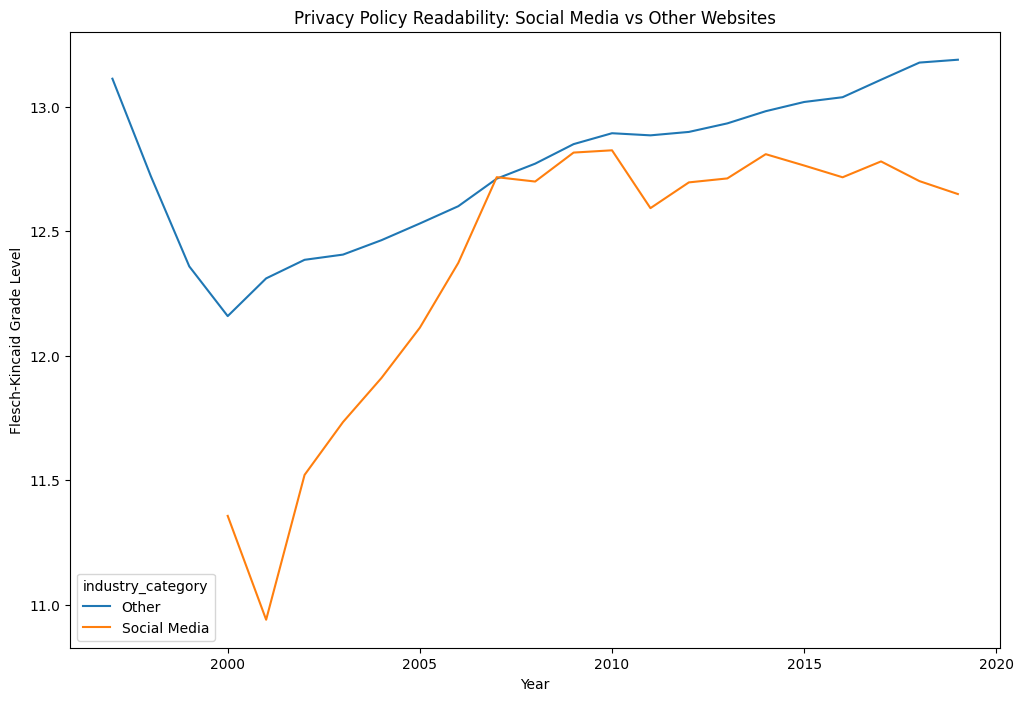

In [26]:
# Define social media category
social_media_industries = ['socialnetworking', 'chatandmessaging', 'mediasharing']

# Create a function to categorize industries without overlap
def categorize_industry(row):
    if any(row[industry] == 1 for industry in social_media_industries):
        return 'Social Media'
    return 'Other'

# Add industry category to the dataframe
df_expanded['industry_category'] = df_expanded.apply(categorize_industry, axis=1)

# Group by year and industry category, calculate mean readability scores
yearly_readability = df_expanded.groupby(['year', 'industry_category'])[['flesch_kincaid', 'smog']].mean().reset_index()

# Plot readability trends
plt.figure(figsize=(12, 8))
sns.lineplot(data=yearly_readability, x='year', y='flesch_kincaid', hue='industry_category')
plt.title('Privacy Policy Readability: Social Media vs Other Websites')
plt.ylabel('Flesch-Kincaid Grade Level')
plt.xlabel('Year')
plt.show()


### Set of high data collection industries

/tmp/ipykernel_108686/763486495.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly_readability = df_expanded.groupby(['year', 'industry_category'])[['flesch_kincaid', 'smog', 'flesch_ease']].mean().reset_index()


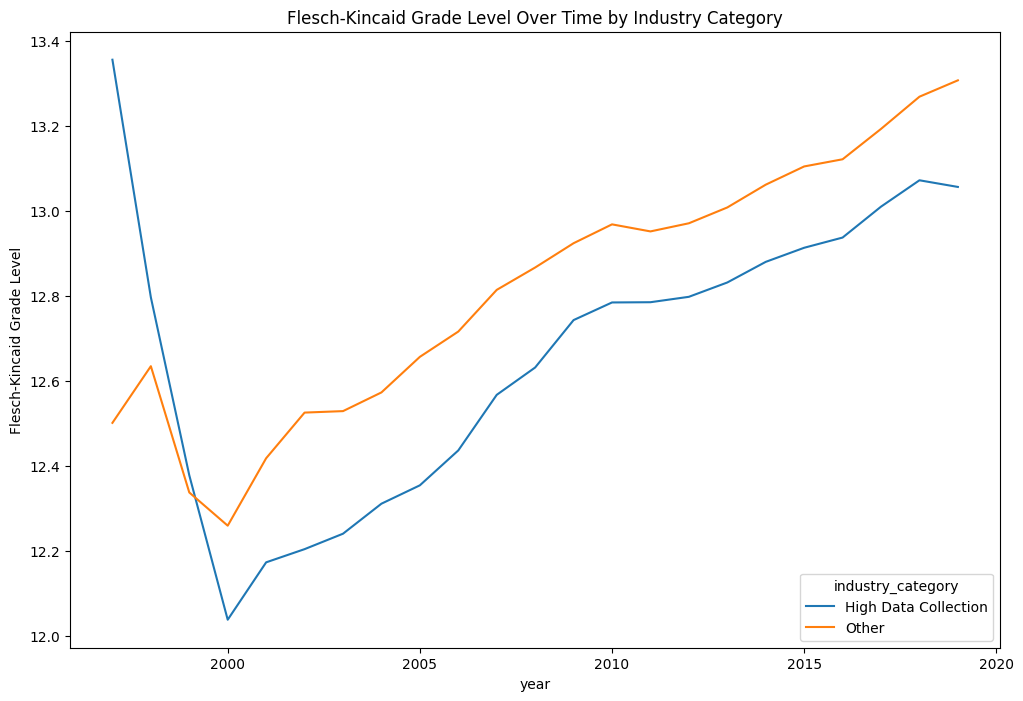

In [27]:
# Define high-data collection industries
high_data_industries = ['advertising', 'socialnetworking', 'chatandmessaging', 'newsandmedia', 'games', 'entertainment', 'informationtech', 'shopping', 'mediasharing', 'searchenginesandportals']

# Create a function to categorize industries without overlap
def categorize_industry(row):
    if any(row[industry] == 1 for industry in high_data_industries):
        return 'High Data Collection'
    return 'Other'

# Add industry category to the dataframe
df_expanded['industry_category'] = df_expanded.apply(categorize_industry, axis=1)

# Group by year and industry category, calculate mean readability scores
yearly_readability = df_expanded.groupby(['year', 'industry_category'])[['flesch_kincaid', 'smog', 'flesch_ease']].mean().reset_index()

# Plot readability trends
plt.figure(figsize=(12, 8))
sns.lineplot(data=yearly_readability, x='year', y='flesch_kincaid', hue='industry_category')
plt.title('Flesch-Kincaid Grade Level Over Time by Industry Category')
plt.ylabel('Flesch-Kincaid Grade Level')
plt.show()


In [28]:
# Repeat for SMOG and Flesch Ease Score

# Statistical analysis
high_data = df_expanded[df_expanded['industry_category'] == 'High Data Collection']
other = df_expanded[df_expanded['industry_category'] == 'Other']

# Perform t-test for Flesch-Kincaid scores
t_stat, p_value = stats.ttest_ind(high_data['flesch_kincaid'], other['flesch_kincaid'])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


T-statistic: nan
P-value: nan


In [29]:

# Analyze impact of GDPR
pre_gdpr = df_expanded[df_expanded['year'] < 2018]
post_gdpr = df_expanded[df_expanded['year'] >= 2018]

# Compare readability before and after GDPR
t_stat_gdpr, p_value_gdpr = stats.ttest_ind(pre_gdpr['flesch_kincaid'], post_gdpr['flesch_kincaid'])

print(f"GDPR Impact - T-statistic: {t_stat_gdpr}")
print(f"GDPR Impact - P-value: {p_value_gdpr}")

GDPR Impact - T-statistic: nan
GDPR Impact - P-value: nan


In [30]:
# Trend analysis
def calculate_trend(group):
    trend = stats.linregress(group['year'], group['flesch_kincaid'])
    return pd.Series({'slope': trend.slope, 'p_value': trend.pvalue})

trends = df_expanded.groupby('industry_category').apply(calculate_trend)
print("Readability Trends by Industry Category:")
print(trends)

Readability Trends by Industry Category:
                      slope  p_value
industry_category                   
High Data Collection    NaN      NaN
Other                   NaN      NaN


## Data breaches?